### Pytorch Transformer on Deca-alanine IC

Where only the bonds are modeled by a univariate Gaussian.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.distributions as dist
import torch.optim as optim

from torch.utils.data import DataLoader
import sys
import os
from einops import rearrange
from torch import nn, einsum

#Custom
import utilities
torch.max_split_size_mb = 2048
import time
import pickle
from mixture_of_experts import MoE

#### Import Dataset, Calculate Means and Covariances of Bonds and Angles

In [2]:
def custom_bucketize(input_, num_bins, lower_bound = -torch.pi, upper_bound = torch.pi, right=True):
    bounds = torch.linspace(start=lower_bound, end=upper_bound, steps=num_bins).to(device)
    return torch.bucketize(input_, bounds).to(device)

def un_bucketize_dict(num_bins, lower_bound = -torch.pi, upper_bound = torch.pi):
    unbucket_dict = dict()
    data_range = upper_bound - lower_bound
    delta = data_range/num_bins
    lower_value = lower_bound + delta/2
    
    for iter in range(0, num_bins+1, 1):
        unbucket_dict[iter] = lower_value
        lower_value = lower_value + delta
        
    return unbucket_dict

def un_bucketize(input_, num_bins, device=torch.device('cuda:0'), 
                 lower_bound = -torch.pi, upper_bound = torch.pi):
    unbucket_dict = un_bucketize_dict(num_bins, lower_bound=-torch.pi, upper_bound=torch.pi)
    np_input = input_.cpu().numpy()
    return torch.tensor( np.vectorize(unbucket_dict.get)(np_input) ).to(device)

def statistical_unbucketize(input_, num_bins, lower_bound=-torch.pi, upper_bound=torch.pi):
    """Unbucketize in a sampling operation"""
    data_linspace = torch.linspace(start=lower_bound, end=upper_bound, steps=GLOBAL_NUM_BINS+1)

    uniform_dist_dict = dict()
    data_range = 2*torch.pi
    delta = data_range/GLOBAL_NUM_BINS
    
    np_input = input_.cpu().numpy()
    
    for iter in range(0, GLOBAL_NUM_BINS, 1):
        lower_range = data_linspace[iter]
        upper_range = data_linspace[iter+1]
        uniform_dist_dict[iter] = torch.distributions.Uniform(lower_range, upper_range)
    
    sample_item = lambda item: item.sample()
    #resol = np.vectorize(sample_item)(result) 

    dist_array =  np.vectorize(uniform_dist_dict.get)(np_input)
    return np.vectorize(sample_item)(dist_array) 

def return_unimodal_multimodal(flattened_data):
    flattened_data = flattened_data.to(device)
    bonds_angles = flattened_data[:, :-99].to(device)
    dihedrals = flattened_data[:, 201:].to(device)
    
    unimodal_dihedrals = torch.index_select(dihedrals, 1, unimodal_indx).to(device)
    pi_dihedrals = torch.index_select(dihedrals, 1, pi_indx).to(device)
    multi_dihedrals = torch.index_select(dihedrals, 1, multimodal_indx).to(device)
    unimodal_data = torch.cat([bonds_angles, unimodal_dihedrals, pi_dihedrals], dim=1).to(device)
    
    return unimodal_data, multi_dihedrals

In [3]:
GLOBAL_HIDDEN_SIZE = 512
GLOBAL_NUM_BINS = 700
GLOBAL_DROPOUT = 0.00
GLOBAL_NUM_ATTN_HEADS = 4
GLOBAL_QKV_DEPTH = 128 #GLOBAL_HIDDEN_SIZE/GLOBAL_NUM_ATTN_HEADS
GLOBAL_BATCH_SIZE = 512
#decoder_specific
GLOBAL_DECODER_EXPERTS = 6
GLOBAL_DECODER_LAYERS = 6
#encoder_specific
GLOBAL_ENCODER_LAYERS = 2
GLOBAL_ENCODER_FILTER_SIZE = GLOBAL_HIDDEN_SIZE*2

In [4]:
MMCD_path = "./"
sys.path.append(MMCD_path)
from mmcd import MMCDataset

name = 'decaalanine'
data_path = os.path.join(MMCD_path, "data")

dataset_train = MMCDataset(root = data_path,
                           molecule_name = name,
                           train = True,
                           coordinate_type = 'internal',
                           lazy_load = False)

train_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = GLOBAL_BATCH_SIZE, #256 is the default batch size
                          shuffle = True)

In [5]:
def return_bonds_dist(data, dec=False):
    if dec==False:
        bonds = data[:, :-19] 
    else:
        bonds = data[:, :-198] #deccalanine has 99 dihedrals and 99 angles
        
    bonds = bonds.permute(1, 0)
    np_bonds = np.array(bonds)
    covar_mat = np.cov(np_bonds)
    means = np.mean(np_bonds, axis = 1)
    tr_covar = torch.tensor(covar_mat).double()
    tr_means = torch.tensor(means).double()
    bonds_dist = dist.MultivariateNormal(loc = tr_means, covariance_matrix = tr_covar)
    
    del tr_covar
    del tr_means 
    
    return bonds_dist

In [6]:
"""
whole_loader = DataLoader(dataset_train,
    num_workers = 1,
    batch_size = 160000, #256 is the default batch size
    shuffle = True)

for batch_idx, (data, _) in enumerate(whole_loader):
    #Flatten the data into a tensor of size (256, 60) tensor before putting it into the GPU
    data = utilities.flatten_data(data) #for deccalanine
    bonds_dist = return_bonds_dist(data, dec=True)

with open('bond_dist.pickle', 'wb') as dist_file:
    pickle.dump(bonds_dist, dist_file)
"""

"\nwhole_loader = DataLoader(dataset_train,\n    num_workers = 1,\n    batch_size = 160000, #256 is the default batch size\n    shuffle = True)\n\nfor batch_idx, (data, _) in enumerate(whole_loader):\n    #Flatten the data into a tensor of size (256, 60) tensor before putting it into the GPU\n    data = utilities.flatten_data(data) #for deccalanine\n    bonds_dist = return_bonds_dist(data, dec=True)\n\nwith open('bond_dist.pickle', 'wb') as dist_file:\n    pickle.dump(bonds_dist, dist_file)\n"

In [7]:
file_to_read = open("bond_dist.pickle", "rb")
bonds_dist = pickle.load(file_to_read)
file_to_read.close()

#### Actual Model

In [8]:
########################
### Encoder, Decoder ###
########################

class DecoderLayer(nn.Module):
    """Implements a single layer of an unconditional ImageTransformer"""
    def __init__(self):
        self.hidden_size = GLOBAL_HIDDEN_SIZE

        super().__init__()
        self.attn = Attn()
        self.dropout = nn.Dropout(p=GLOBAL_DROPOUT)
        self.layernorm_attn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.layernorm_attn2 = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.layernorm_ffn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        
        self.MoE = MoE(
            dim = GLOBAL_HIDDEN_SIZE,
            num_experts = GLOBAL_DECODER_EXPERTS, # increase the experts (# parameters) of your model without increasing computation
            hidden_dim = GLOBAL_HIDDEN_SIZE * 4, #size of hidden dimension in each expert, defaults to 4 * dimension
            activation = nn.LeakyReLU,      # use your preferred activation, will default to GELU
            second_policy_train = 'random', # in top_2 gating, policy for whether to use a second-place expert
            second_policy_eval = 'random',  # all (always) | none (never) | threshold (if gate value > the given threshold) | random (if gate value > threshold * random_uniform(0, 1))
            second_threshold_train = 0.2,
            second_threshold_eval = 0.2,
            capacity_factor_train = 1.25,   # experts have fixed capacity per batch. we need some extra capacity in case gating is not perfectly balanced.
            capacity_factor_eval = 2.,      # capacity_factor_* should be set to a value >=1
            loss_coef = 1e-2                # multiplier on the auxiliary expert balancing auxiliary loss
        ).to(device)

    def forward(self, X, encoder_output=None):
        #the first layer of a decoder is just normal self-attention
        y = self.attn(X, use_encoder_output=False, autoregressive_mask=True)
        X = self.layernorm_attn(self.dropout(y) + X)
        #the second layer of a decoder uses outputs from the encoder as query and key values
        y = self.attn(X, encoder_output=encoder_output, 
            use_encoder_output=True, autoregressive_mask=True)
        X = self.layernorm_attn2(self.dropout(y) + X)
        #but note that both attentions need masking
        y, _ = self.MoE(X)
        X = self.layernorm_ffn(self.dropout(y) + X)
        return X

class EncoderLayer(nn.Module):
    "The encoder is also identical to the decoder, except that the decoder has masking operation" 
    def __init__(self):
        self.hidden_size = GLOBAL_HIDDEN_SIZE
        self.filter_size = GLOBAL_ENCODER_FILTER_SIZE
        super().__init__()
        self.attn = Attn()
        self.dropout = nn.Dropout(p=GLOBAL_DROPOUT)
        self.layernorm_attn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.layernorm_ffn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.ffn = nn.Sequential(nn.Linear(self.hidden_size, self.filter_size, bias=True),
                   nn.ReLU(), nn.Linear(self.filter_size, self.hidden_size, bias=True))

    def forward(self, X):
        y = self.attn(X, autoregressive_mask=False)
        X = self.layernorm_attn(self.dropout(y) + X)
        y = self.ffn(X)
        X = self.layernorm_ffn(self.dropout(y) + X)
        return X

############
### Attn ###
############

class Attn(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = GLOBAL_HIDDEN_SIZE
        self.num_heads = GLOBAL_NUM_ATTN_HEADS
        self.kd = GLOBAL_QKV_DEPTH*self.num_heads
        self.vd = GLOBAL_QKV_DEPTH*self.num_heads

        self.q_dense = nn.Linear(self.hidden_size, self.kd, bias=False)
        self.k_dense = nn.Linear(self.hidden_size, self.kd, bias=False)
        self.v_dense = nn.Linear(self.hidden_size, self.vd, bias=False)
        self.output_dense = nn.Linear(self.vd, self.hidden_size, bias=False)
        
        assert self.kd % self.num_heads == 0
        assert self.vd % self.num_heads == 0

    def dot_product_attention(self, q, k, v, bias=None):
        logits = torch.einsum("...kd,...qd->...qk", k, q)
        if bias is not None:
            logits += bias
        weights = F.softmax(logits, dim=-1)
        return weights @ v

    def forward(self, X, encoder_output=None, autoregressive_mask=True, use_encoder_output=False):
        if use_encoder_output == False: 
            q = self.q_dense(X)
            k = self.k_dense(X)
            v = self.v_dense(X)
        elif use_encoder_output == True: 
            v = self.v_dense(X)
            q = self.q_dense(encoder_output.clone())
            k = self.k_dense(encoder_output.clone())

        #Split to shape [batch_size, num_heads, len, depth / num_heads]
        q = q.view(q.shape[:-1] + (self.num_heads, self.kd // self.num_heads)).permute([0, 2, 1, 3])
        k = k.view(k.shape[:-1] + (self.num_heads, self.kd // self.num_heads)).permute([0, 2, 1, 3])
        v = v.view(v.shape[:-1] + (self.num_heads, self.vd // self.num_heads)).permute([0, 2, 1, 3])
        q *= (self.kd // self.num_heads) ** (-0.5) #normalized dot product or something
        
        if autoregressive_mask == True: 
            bias = -1e10*torch.triu(torch.ones(X.shape[1], X.shape[1]), 1).to(X.device)
            result = self.dot_product_attention(q, k, v, bias=bias)
        elif autoregressive_mask == False: 
            result = self.dot_product_attention(q, k, v, bias=None)

        result = result.permute([0, 2, 1, 3]).contiguous()
        result = result.view(result.shape[0:2] + (-1,))
        result = self.output_dense(result)
        return result

##########################
### Actual Transformer ###
##########################

class TransformerIC(nn.Module):
    def __init__(self, given_dist):
        super(TransformerIC, self).__init__()
        #model specific params
        self.hidden_size = GLOBAL_HIDDEN_SIZE
        self.num_bins = GLOBAL_NUM_BINS
        self.dropout = GLOBAL_DROPOUT
        self.dnlayers = GLOBAL_DECODER_LAYERS
        self.enlayers = GLOBAL_ENCODER_LAYERS
        #data specific params
        self.batch_size = GLOBAL_BATCH_SIZE
        self.num_encoder_dim = 102 #99+3
        self.num_decoder_dim = 198 #99
        #given unimodal dist
        self.encoder_dist = given_dist
        #functions
        self.output_function = torch.nn.Softmax(dim=1)
        self.loss_function = nn.CrossEntropyLoss()
        self.loss_function_no_sum = nn.CrossEntropyLoss(reduction="none")
        #model components
        self.embeds = nn.Embedding(self.num_bins, self.hidden_size)
        self.input_dropout = nn.Dropout(self.dropout)
        self.output_dense = nn.Linear(self.hidden_size, self.num_bins, bias=True)
        self.decoderlayers = nn.ModuleList([DecoderLayer() for _ in range(self.dnlayers)])
        self.encoderlayers = nn.ModuleList([EncoderLayer() for _ in range(self.enlayers)])
        self.pos_embedder_1 = torch.nn.Embedding(self.num_decoder_dim, 
            self.hidden_size) #decoder pos embedding
        #reshape encoder output
        self.pos_embedder_0 = torch.nn.Embedding(self.num_decoder_dim, self.hidden_size) #encoder_positional_encoding
        self.vd = GLOBAL_QKV_DEPTH 
        self.encoder_embeds = nn.Linear(self.num_encoder_dim, self.hidden_size*self.num_decoder_dim)
        self.encoder_reshape = nn.Linear(self.hidden_size, self.vd, bias=False)
    
    def shift_and_pad_(self, X): 
        """For the purpose of autoregressive property. Shift inputs over by 1 and pad.
        x should be [256, 19, 8]. Pad 2nd to last dimension, 
        since 1st dimension is batch and last is embedding."""
        X = X[:, :-1, :]
        X = F.pad(X, (0, 0, 1, 0)) #kinda need to figure out how this works
        return X

    def forward(self, decoder_input=None, encoder_input=None, encoder_output=None, sampling=False, return_encoder=False):
        #activates the decoder only
        if encoder_output == None:
            encoder_output = self.encoder_embeds(encoder_input)
            #normalize properly
            encoder_output = encoder_output.view((encoder_input.shape[0], 
                self.num_decoder_dim, self.hidden_size)) * (self.hidden_size ** 0.5)
            #inject positional information for encoder
            pos_index = torch.arange(0, self.num_decoder_dim).repeat(encoder_input.size()[0], 1).to(device)
            pos_embeddings = self.pos_embedder_0(pos_index)
            encoder_output = pos_embeddings + encoder_output
            #pass through encoder layers
            for layer in self.encoderlayers:
                encoder_output = layer(encoder_output)
            if return_encoder == True:
                return encoder_output
            
        #not used in training, but used by sapling
        if sampling:
            curr_infer_length = decoder_input.shape[1]
            decoder_input = F.pad(decoder_input, (0, self.num_decoder_dim - curr_infer_length))  
            
        #apply embedding and shift and pad
        decoder_input = self.shift_and_pad_(self.embeds(decoder_input) * (self.hidden_size ** 0.5))
        #apply positional embedding
        pos_index = torch.arange(0, self.num_decoder_dim).repeat(decoder_input.size()[0], 1).to(device)
        decoder_input = decoder_input + self.pos_embedder_1(pos_index)
        
        for layer in self.decoderlayers:
            decoder_input = layer(decoder_input, encoder_output = encoder_output) 
        
        decoder_input = self.output_dense(decoder_input) 
        
        return decoder_input

    def sample(self, batch_size, device, detach=False): #batch size is num samples
        """sampling procedure does not require gradients"""
        encoder_data = self.encoder_dist.sample(torch.tensor([batch_size])).to(device).float()
        encoder_output = self.forward(decoder_input=None, encoder_input=encoder_data, return_encoder=True)
        
        if detach==True:
            encoder_data = encoder_data.detach()

        total_len = self.num_decoder_dim
        samples = torch.zeros((batch_size, 1)).to(device).long()
        
        if detach == True:
            samples = samples.detach()

        for curr_infer_length in range(total_len):
            outputs = self.forward(decoder_input=samples, encoder_output=encoder_output, 
                                   sampling=True)
            
            outputs = outputs[:, curr_infer_length]
            
            categorical = self.output_function(outputs) #outputs is energy
            temp_distribution = dist.Categorical(torch.squeeze(categorical))
            x = temp_distribution.sample()
            x = x.unsqueeze(dim=1)#print(categorical.size()) = [10, 629]
            if curr_infer_length == 0:
                samples = x
            else:
                samples = torch.cat([samples, x], 1)

        return encoder_data, samples

    def loss(self, X, Y, with_energy=False, reduce=True):
        #X is a categorical distribution and Y is the target (one hot encoding).
        X = X.permute(0, 2, 1)
        #X.size() = [256, 19, 629] after permuting; Y.size() = [256, 19]
        #256 = batchsize, 629 = number classes, 19 = number of dihedrals
        if reduce==False:
            return self.loss_function_no_sum(X, Y)
        loss_value = self.loss_function(X, Y) #nn.CrossEntropyLoss automatically applies softmax
        return loss_value
    
    def exact_log_likelihood(self, ba, dihedrals):
        #dihedrals should be represented as indicies already
        dist = self.forward(dihedrals=dihedrals, ba=ba)
        #dist = dist.permute(0, 2, 1)
        ba_loss = self.unimodal_dist.log_prob(ba.cpu())
        dihedral_loss = self.loss(dist.to(device), dihedrals.to(device), reduce=False).to(device) #+ \
        #self.ba_dist.log_prob(ba.to(device)).to(device)    
        dihedral_loss = torch.sum(dihedral_loss, dim=1)
        loss = torch.add(ba_loss.to(device), dihedral_loss.to(device))
        return loss

    def energy_loss(self, batch_size, device, sum=False):
        ba, dihedral = model.sample(batch_size, device=device)
        dihedral_true = utilities.index_to_number(dihedral)
        q_s = (-model.exact_log_likelihood(ba=ba, dihedrals=dihedral))
        E_s = dataset_train.compute_potential_energy_for_ic(
            utilities.rebuild(
                torch.cat([ba, dihedral_true], dim=1).cpu().detach()
            ), unitless=False
        )
        return torch.sum(torch.add(torch.tensor(E_s).to(device), q_s.to(device)))

device = torch.device("cuda")
model = TransformerIC(given_dist = bonds_dist).to(device)
#bonds = torch.randn((GLOBAL_BATCH_SIZE, 102)).to(device)
#decoder = torch.ones((GLOBAL_BATCH_SIZE, 198)).to(device).long()
#model.forward(decoder_input = decoder, encoder_input = bonds)
#res = model.sample(64, device="cuda:0")

In [9]:
model = nn.DataParallel(model)

global_loss_function = nn.CrossEntropyLoss()

def loss_parallel(X, Y):
    X = X.permute(0, 2, 1)
    return global_loss_function(X, Y)

In [11]:
model.load_state_dict(torch.load("angles_dihedrals_decoder_state_dict.pth"))

<All keys matched successfully>

In [ ]:
loss_over_time = []
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.0001) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 10, eta_min=0, last_epoch=- 1, verbose=False)

def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        
        data = utilities.flatten_data(data)
        data = data.to(device)
        
        bonds = data[:, :-99*2]
        angles_dihedrals = data[:, 102:]
        angles_dihedrals =  custom_bucketize(input_=angles_dihedrals, num_bins=GLOBAL_NUM_BINS)
        true_target = angles_dihedrals

        optimizer.zero_grad()
        X_pred = model(decoder_input=angles_dihedrals, encoder_input=bonds) 
        
        loss = loss_parallel(X=X_pred, Y=true_target) 
        total_loss = loss #+ model.energy_loss(50, device=device)
        
        total_loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 50 == 0:#args.log_interval == 0: #by default, args.log_interval = 10
            print('Train Epoch:', epoch, '[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx, #index of the batch we are on 
                len(train_loader), #how many batches are in the data loader
                100. * batch_idx / len(train_loader), #progress percentage
                loss.item() / GLOBAL_BATCH_SIZE#,  #hardcoded batch size
                ))
        
            loss_over_time.append(loss.item()/len(train_loader) )
            torch.set_printoptions(threshold=10_000)

for epoch in range(0, 60, 1):
    train(epoch)
    scheduler.step()

/state/partition1/slurm_tmp/19420469.0.0/ipykernel_46119/3313736123.py:3: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/aten/src/ATen/native/BucketizationUtils.h:33.)
  return torch.bucketize(input_, bounds).to(device)


Train Epoch: 0 [0/313 (0%)]	Loss: 0.007277
Train Epoch: 0 [50/313 (16%)]	Loss: 0.007301
Train Epoch: 0 [100/313 (32%)]	Loss: 0.007294
Train Epoch: 0 [150/313 (48%)]	Loss: 0.007295
Train Epoch: 0 [200/313 (64%)]	Loss: 0.007291
Train Epoch: 0 [250/313 (80%)]	Loss: 0.007300
Train Epoch: 0 [300/313 (96%)]	Loss: 0.007288
Train Epoch: 1 [0/313 (0%)]	Loss: 0.007297
Train Epoch: 1 [50/313 (16%)]	Loss: 0.007290
Train Epoch: 1 [100/313 (32%)]	Loss: 0.007287
Train Epoch: 1 [150/313 (48%)]	Loss: 0.007298
Train Epoch: 1 [200/313 (64%)]	Loss: 0.007287
Train Epoch: 1 [250/313 (80%)]	Loss: 0.007289
Train Epoch: 1 [300/313 (96%)]	Loss: 0.007296
Train Epoch: 2 [0/313 (0%)]	Loss: 0.007284
Train Epoch: 2 [50/313 (16%)]	Loss: 0.007286
Train Epoch: 2 [100/313 (32%)]	Loss: 0.007282
Train Epoch: 2 [150/313 (48%)]	Loss: 0.007278
Train Epoch: 2 [200/313 (64%)]	Loss: 0.007292
Train Epoch: 2 [250/313 (80%)]	Loss: 0.007290
Train Epoch: 2 [300/313 (96%)]	Loss: 0.007291
Train Epoch: 3 [0/313 (0%)]	Loss: 0.007280
Tra

Train Epoch: 25 [200/313 (64%)]	Loss: 0.007205
Train Epoch: 25 [250/313 (80%)]	Loss: 0.007198
Train Epoch: 25 [300/313 (96%)]	Loss: 0.007213
Train Epoch: 26 [0/313 (0%)]	Loss: 0.007176
Train Epoch: 26 [50/313 (16%)]	Loss: 0.007180
Train Epoch: 26 [100/313 (32%)]	Loss: 0.007182
Train Epoch: 26 [150/313 (48%)]	Loss: 0.007188
Train Epoch: 26 [200/313 (64%)]	Loss: 0.007184
Train Epoch: 26 [250/313 (80%)]	Loss: 0.007190
Train Epoch: 26 [300/313 (96%)]	Loss: 0.007186
Train Epoch: 27 [0/313 (0%)]	Loss: 0.007174
Train Epoch: 27 [50/313 (16%)]	Loss: 0.007177
Train Epoch: 27 [100/313 (32%)]	Loss: 0.007173
Train Epoch: 27 [150/313 (48%)]	Loss: 0.007177
Train Epoch: 27 [200/313 (64%)]	Loss: 0.007170
Train Epoch: 27 [250/313 (80%)]	Loss: 0.007174
Train Epoch: 27 [300/313 (96%)]	Loss: 0.007177
Train Epoch: 28 [0/313 (0%)]	Loss: 0.007166
Train Epoch: 28 [50/313 (16%)]	Loss: 0.007155
Train Epoch: 28 [100/313 (32%)]	Loss: 0.007171
Train Epoch: 28 [150/313 (48%)]	Loss: 0.007150
Train Epoch: 28 [200/313 

### Training Loop

In [ ]:
loss_over_time = []
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.000035) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 0.000035, eta_min=0, last_epoch=- 1, verbose=False)

def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        
        data = utilities.flatten_data(data)
        data = data.to(device)
        
        bonds = data[:, :-99*2]
        angles_dihedrals = data[:, 102:]
        angles_dihedrals =  custom_bucketize(input_=angles_dihedrals, num_bins=GLOBAL_NUM_BINS)
        true_target = angles_dihedrals

        optimizer.zero_grad()
        X_pred = model(decoder_input=angles_dihedrals, encoder_input=bonds) 
        
        loss = loss_parallel(X=X_pred, Y=true_target) 
        total_loss = loss #+ model.energy_loss(50, device=device)
        
        total_loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 10 == 0:#args.log_interval == 0: #by default, args.log_interval = 10
            print('Train Epoch:', epoch, '[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx, #index of the batch we are on 
                len(train_loader), #how many batches are in the data loader
                100. * batch_idx / len(train_loader), #progress percentage
                loss.item() / GLOBAL_BATCH_SIZE#,  #hardcoded batch size
                ))
        
            loss_over_time.append(loss.item()/len(train_loader) )
            torch.set_printoptions(threshold=10_000)

for epoch in range(0, 120, 1):
    train(epoch)
    scheduler.step()

1893


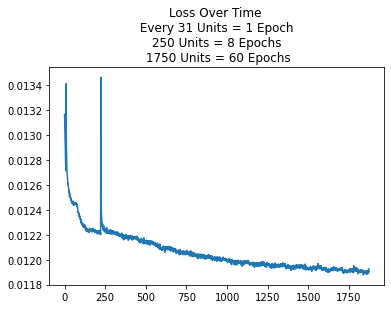

In [54]:
ls = np.array(loss_over_time)
print(np.size(ls))
plt.plot(ls[20:])
plt.title("Loss Over Time \n Every 31 Units = 1 Epoch \n 250 Units = 8 Epochs \n 1750 Units = 60 Epochs")
plt.show()

$ 3.5 \cdot 10^{-5} $

### Sample From Model to View Distribtuions

In [ ]:
sample_loader = DataLoader(dataset_train,
                          num_workers = 4,
                          batch_size = 1000, #256 is the default batch size
                          shuffle = True)

for batch_idx, (data, _) in enumerate(sample_loader):
    data = utilities.flatten_data(data)
    np_data = np.array(data)
    break

del sample_loader

In [ ]:
device = torch.device("cpu")
model.to(device)

torch.cuda.empty_cache()
torch.cuda.synchronize()

In [ ]:
device = torch.device("cuda:1")
model.to(device)

ba, dihedrals = model.module.sample(100, device=device)
for index in range(0, 19, 1):
    print(index)
    new_ba, new_dihedrals = model.module.sample(100, device=device)
    ba = torch.cat([ba, new_ba], dim=0)
    dihedrals = torch.cat([dihedrals, new_dihedrals], dim=0)

In [ ]:
dihedral_val = statistical_unbucketize(dihedrals, GLOBAL_NUM_BINS, lower_bound=-torch.pi, upper_bound=torch.pi)

In [ ]:
whole = torch.cat([torch.tensor(ba).to(device), torch.tensor(dihedral_val).to(device)], dim=1)

### Calculate Energies

In [ ]:
def rebuild(flat, data_length = 99):
    #data_length = 19 #this is particular to dialene
    result = {}
    result['reference_particle_1_xyz'] = torch.zeros((flat.shape[0], 3))
    result['reference_particle_2_bond'] = flat[:, 0]
    result['reference_particle_3_bond'] = flat[:, 1]
    result['reference_particle_3_angle'] = flat[:, 2]

    start = 3
    end = start + data_length
    result['bond'] = flat[:, start:end]

    start = end
    end = start + data_length
    result['angle'] = flat[:, start:end]

    start = end
    end = start + data_length
    result['dihedral'] = flat[:, start:end]

    return result

In [ ]:
device = torch.device('cpu')

In [ ]:
molecules = rebuild(torch.tensor(whole).to(device), data_length=99)
potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(molecules)

In [ ]:
dataset_test = MMCDataset(root = './data',
                           molecule_name = name,
                           train = False,
                           coordinate_type = 'internal')

dataloader_test = DataLoader(dataset_test,
                              num_workers = 8,
                              batch_size = 1280,
                              shuffle = False)

In [ ]:
potential_energy_md = np.concatenate(
    [dataset_train.potential_energy_kJ_per_mole,
     dataset_test.potential_energy_kJ_per_mole]
)

In [ ]:
p_x = np.concatenate(
    [dataset_train.potential_energy_kJ_per_mole,
     dataset_test.potential_energy_kJ_per_mole]
)

In [ ]:
potential_energy_q_theta

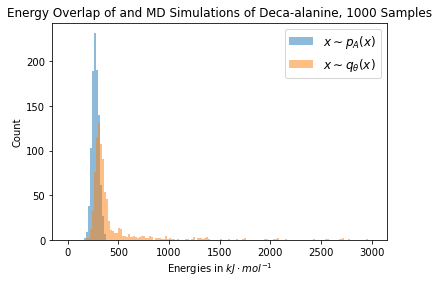

In [47]:
plt.hist(potential_energy_md[:1000], range =(0, 3000), bins = 150, alpha = 0.5, label = "$x \sim p_A(x)$")
plt.hist(potential_energy_q_theta, range =(0, 3000), bins = 150, alpha = 0.5, label = "$x \sim q_{\\theta}(x)$")
plt.title("Energy Overlap of and MD Simulations of Deca-alanine, 1000 Samples \n Decoder Generates Angles and Dihedrals")
plt.legend(prop={'size': 12})
plt.xlabel('Energies in $kJ \cdot mol^{-1}$')
plt.ylabel('Count')
plt.show()

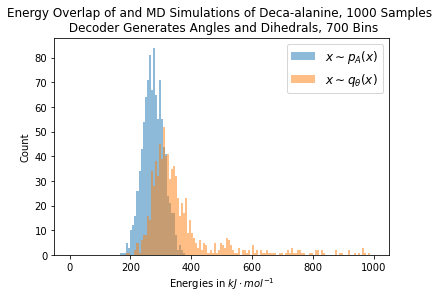

In [52]:
plt.hist(potential_energy_md[:1000], range =(0, 1000), bins = 150, alpha = 0.5, label = "$x \sim p_A(x)$")
plt.hist(potential_energy_q_theta, range =(0, 1000), bins = 150, alpha = 0.5, label = "$x \sim q_{\\theta}(x)$")
plt.title("Energy Overlap of and MD Simulations of Deca-alanine, 1000 Samples \n Decoder Generates Angles and Dihedrals, 700 Bins")
plt.legend(prop={'size': 12})
plt.xlabel('Energies in $kJ \cdot mol^{-1}$')
plt.ylabel('Count')
plt.show()

In [43]:
def count_parameters(model):
    #table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        #table.add_row([name, params])
        total_params+=params
    #print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

Total Trainable Params: 97454780


97454780

In [51]:
torch.save(model.state_dict(), "angles_dihedrals_decoder_state_dict.pth")
torch.save(model, "angles_dihedrals_decoder.pth")

### Notes

$$p(x_n,...,x_1)  = p(x_n|x_{(n-1)},...,x_1) \cdot ... \cdot p(x_1)$$

$$p(x_n,...,x_1) = \frac{e^{-\beta E_{\theta}(x_n ; x...)}}{\int_{-\pi}^{\pi} e^{-\beta E_{\theta}(x_n; x...)} dx_n} \cdot ... \cdot \frac{e^{-\beta E_{\theta}(x)}}{\int_{-\pi}^{\pi} e^{-\beta E_{\theta}(x)} dx}$$

$$p(x_n, x_1) \approx \frac{e^{-\beta E_{\theta}(x_n; x...)}}{\sum_{n=1}^{629} e^{-\beta E_{\theta}(x_n; x...)}} \cdot ... \cdot \frac{e^{-\beta E_{\theta}(x)}}{\sum_{n=1}^{629} e^{-\beta E_{\theta}(x)} }$$